# Make symbolic formula with KAN

## Setup
- Dataset: ASCADv1 (fixed key)
- Leakage: Mask of SBox output
- PoI: [156]
- KAN's width: [1, 1, 2]
- KAN's output activation: softmax

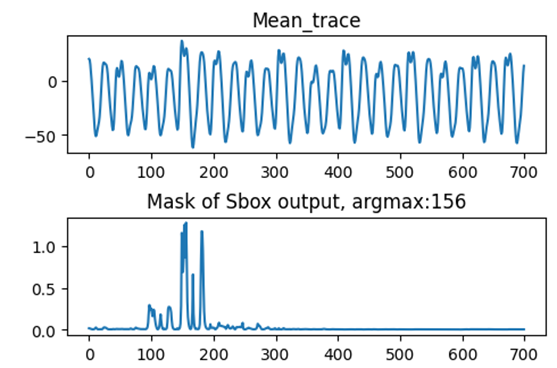

In [1]:
import torch
from pathlib import Path
import os
import hydra
import numpy as np
import matplotlib.pyplot as plt
import pickle

os.chdir('/workspace')
import src

In [2]:
with hydra.initialize(config_path="../conf", version_base='1.1'):
    cfg = hydra.compose(
        config_name='config',
        overrides=[
            "model=KAN1h",
            "model.model.width.0=1",
            "model.model.width.1=1",
            "model.train_params.steps=5000",
            "dataset@train=ASCADf_profiling",
            "dataset@test=ASCADf_attack",
            "trace_transforms=set_poi",
            "trace_transforms.transforms.0.pois=[[156, 157, 1]]",
            "trace_transforms.output_size=2",
            "label_transforms=bit",
            "label_transforms.transforms.3.pos=0",
            "save_path=/workspace/results/exp1/",
            "n_attack_traces=2000"
            ]
        )

In [3]:
device = hydra.utils.instantiate(cfg.device)
cpu = torch.device('cpu')

Setup dataset

In [4]:
profiling_dataset = hydra.utils.instantiate(cfg.train.dataset)
test_dataset = hydra.utils.instantiate(cfg.test.dataset)

train_dataloader = torch.utils.data.DataLoader(
    profiling_dataset, batch_size=cfg.train.batch_size, shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=cfg.test.batch_size, shuffle=False
)
KANds = src.utils.to_KAN_dataset(
    train_dataloader, test_dataloader,
    device=device)

Train KAN

In [5]:
model = hydra.utils.instantiate(cfg.model.model)
if not Path(cfg.save_path, cfg.model_name+'.ckpt').exists():
    model = model.to(device)
    _ = model.train(
        KANds,
        **hydra.utils.instantiate(cfg.model.train_params)
        )
    Path(cfg.save_path).mkdir(exist_ok=True, parents=True)
    model.to(cpu).save_ckpt(cfg.model_name+'.ckpt', cfg.save_path)
else:
    model.load_ckpt(cfg.model_name+'.ckpt', cfg.save_path)
model = model.to(device)

train loss: 8.39e-01 | test loss: 8.31e-01 | reg: 2.03e-01 : 100%|█| 5000/5000 [03:15<00:00, 25.53it


save this model to /workspace/results/exp1//KAN-1Hidden.ckpt


Evaluation

In [6]:
preds, labels, th = src.utils.make_prediction(
    model, test_dataloader, device,
    cfg.label_transforms.one_hot)
preds_class = np.argmax(preds, axis=1)
accuracy = np.mean(labels == preds_class)
print('Accuracy: ', accuracy)

Accuracy:  0.5286


In [7]:
_ = src.utils.make_confmat(
    preds_class, labels, accuracy, cfg.save_path)

Calculate guessing entropy

In [8]:
correct_key = test_dataset.key[0][cfg.target_byte]
key_hyposesis = range(256)
if not Path(cfg.save_path, 'label_hyposesis.npy').exists():
    label_hyposesis = src.utils.make_label_hyposesis(
        test_dataset, key_hyposesis, one_hot=cfg.label_transforms.one_hot)
    np.save(Path(cfg.save_path, 'label_hyposesis.npy'), label_hyposesis)
label_hyposesis = np.load(Path(cfg.save_path, 'label_hyposesis.npy'))
ge = src.sca_utils.calc_guessing_entropy(
    preds, label_hyposesis, correct_key,
    cfg.n_attack_traces, n_trial=cfg.n_trials)

Calculating GE [/trials]: 100%|██████████| 40/40 [00:02<00:00, 18.08it/s]


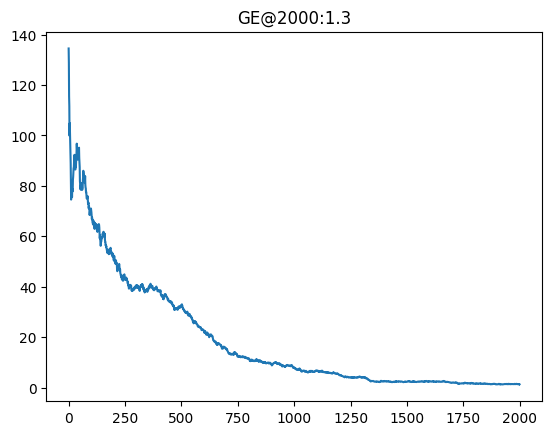

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ge)
ax.set_title(f'GE@{cfg.n_attack_traces}:{ge[-1]}')
fig.savefig(Path(cfg.save_path, f'{cfg.model.name}.png'), dpi=300)

Plot trained KAN

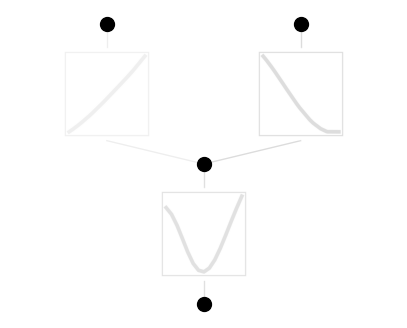

In [10]:
test_inputs = torch.tensor(
    np.array([test_dataset[v][0] for v in range(cfg.n_attack_traces)])).to(device)
_ = model(test_inputs)
model.plot(folder=cfg.save_path+'/attack')
plt.savefig(
    Path(cfg.save_path, f'{cfg.model.name}_attack.png'),
    dpi=300)
src.utils.plot_KAN(cfg, model, 'attack')

Set symbolic functions

In [11]:
model.fix_symbolic(0,0,0, 'x^2')
model.fix_symbolic(1,0,0, 'x')
model.fix_symbolic(1,0,1, 'x')

r2 is 0.9725959300994873
r2 is 0.9935711026191711
Best value at boundary.
r2 is 0.9955804347991943


tensor(0.9956, device='cuda:0', grad_fn=<SelectBackward0>)

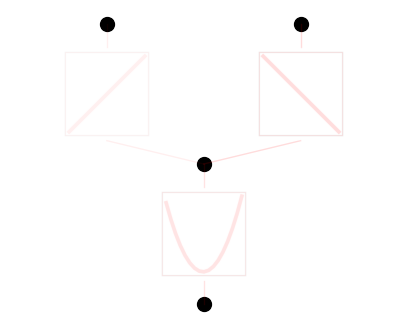

In [12]:
model(KANds['train_input'])
model.plot()

Fine-tuning

In [13]:
_ = model.train(
    KANds,
    **hydra.utils.instantiate(cfg.model.train_params)
    )

train loss: 8.27e-01 | test loss: 8.28e-01 | reg: 2.31e-01 : 100%|█| 5000/5000 [03:09<00:00, 26.38it


Evaluate

In [14]:
preds, labels, th = src.utils.make_prediction(
    model, test_dataloader, device,
    cfg.label_transforms.one_hot)

preds_class = np.argmax(preds, axis=1)
accuracy = np.mean(labels == preds_class)
print('Accuracy: ', accuracy)

Accuracy:  0.4982


In [15]:
ge = src.sca_utils.calc_guessing_entropy(
    preds, label_hyposesis, correct_key,
    cfg.n_attack_traces, n_trial=cfg.n_trials)

Calculating GE [/trials]: 100%|██████████| 40/40 [00:01<00:00, 32.75it/s]


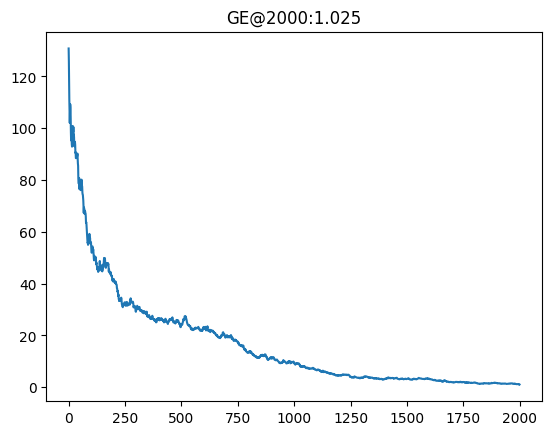

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ge)
ax.set_title(f'GE@{cfg.n_attack_traces}:{ge[-1]}')
fig.savefig(Path(cfg.save_path, f'{cfg.model.name}.png'), dpi=300)

Make symbolic formula

In [17]:
formula, variables = model.symbolic_formula()
with open(Path(cfg.save_path, 'symbolic_fomula.pkl'), mode='wb') as f:
    pickle.dump((formula, variables), f)

In [18]:
formula[1]

0.06 - 0.1*(-x_1 - 0.07)**2